In [1]:
import kinodata
from kinodata.data import KinodataDocked, Filtered
from kinodata.data.data_module import create_dataset
from kinodata.data.grouped_split import KinodataKFoldSplit
from kinodata.transform import TransformToComplexGraph, FilterDockingRMSD
from kinodata.types import *
from kinodata.data.utils.dataset_key import KinodataChemblKey


import json
from pathlib import Path
from typing import Any

import torch

import kinodata.configuration as cfg
from kinodata.model import ComplexTransformer, DTIModel, RegressionModel
from kinodata.model.complex_transformer import make_model as make_complex_transformer
from kinodata.model.dti import make_model as make_dti_baseline
from kinodata.data.data_module import make_kinodata_module
from kinodata.transform import TransformToComplexGraph

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import tqdm

!wandb disabled

W&B disabled.


### Grab some example complex data object

In [2]:
dataset = KinodataDocked()

### Get pocket mol2 file for data object and read it

In [5]:
# for access to mol2 file via ident 
df = pd.read_csv('../data/raw/kinodata3d_meta.csv', index_col='activities.activity_id')

In [32]:
key = KinodataChemblKey(dataset)

In [33]:
identaids = pd.read_csv('../data/processed/ident_aids.csv')

In [88]:
ident = identaids.set_index('ident').loc[44811]['activities.activity_id']
demo_data = dataset[key[ident]]

In [89]:
pocketfile = lambda ident: f'../data/raw/mol2/pocket/{df.loc[ident]['similar.klifs_structure_id']}_pocket.mol2'

In [90]:
from kinodata.data.io.read_klifs_mol2 import read_klifs_mol2
pocket_df = read_klifs_mol2(pocketfile(ident), with_bonds=False)
pocket_df

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,atom.status_bit
0,1,N,9.6945,18.478701,50.158298,N.3,1,LYS838,0.0,BACKBONE
1,2,H,8.9168,18.757500,50.739201,H,1,LYS838,0.0,BACKBONE
2,3,CA,9.6866,17.128901,49.583599,C.3,1,LYS838,0.0,BACKBONE
3,4,HA,10.7091,16.754400,49.631302,H,1,LYS838,0.0,BACKBONE
4,5,C,9.2252,17.140900,48.140499,C.2,1,LYS838,0.0,BACKBONE
...,...,...,...,...,...,...,...,...,...,...
1356,1357,O,7.1765,14.543900,37.111401,O.2,85,ALA1050,0.0,BACKBONE
1357,1358,CB,7.4855,17.359200,36.694302,C.3,85,ALA1050,0.0,<NA>
1358,1359,HB1,6.4585,17.497700,36.356400,H,85,ALA1050,0.0,<NA>
1359,1360,HB2,8.0260,18.302000,36.610001,H,85,ALA1050,0.0,<NA>


#### must remove hydrogens to match complex representation

In [91]:
non_hydrogen = pocket_df["atom.type"] != "H"

#### try matching

In [92]:
pocket_df[non_hydrogen][["atom.x", "atom.y", "atom.z"]]

,atom.x,atom.y,atom.z
0,9.6945,18.478701,50.158298
2,9.6866,17.128901,49.583599
4,9.2252,17.140900,48.140499
5,8.4280,17.973200,47.782600
6,8.7384,16.218599,50.379398
...,...,...,...
1351,8.2361,16.747999,34.452702
1353,8.1670,16.303301,35.830101
1355,7.4631,14.958100,35.987099
1356,7.1765,14.543900,37.111401


In [93]:
demo_data["pocket"].pos.shape

torch.Size([652, 3])

In [94]:
demo_data["pocket"].pos

tensor([[ 9.6945, 18.4787, 50.1583],
        [ 9.6866, 17.1289, 49.5836],
        [ 9.2252, 17.1409, 48.1405],
        ...,
        [ 7.4631, 14.9581, 35.9871],
        [ 7.1765, 14.5439, 37.1114],
        [ 7.4855, 17.3592, 36.6943]])

In [95]:
# match?
np.all(pocket_df[non_hydrogen][["atom.x", "atom.y", "atom.z"]].values == demo_data["pocket"].pos.numpy())

True

In [96]:
interactions = pd.read_csv(f'../data/interaction_analysis/{ident}.csv')

interactions

,interaction_type,residue
0,hydrophobic_interactions,3
1,hydrophobic_interactions,11
2,hydrophobic_interactions,45
3,hydrophobic_interactions,77
4,hydrophobic_interactions,15
5,hydrophobic_interactions,17
6,hydrophobic_interactions,82
7,hydrophobic_interactions,24
8,hydrophobic_interactions,28
9,hydrogen_bonds,3


In [97]:
pocket_df

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,atom.status_bit
0,1,N,9.6945,18.478701,50.158298,N.3,1,LYS838,0.0,BACKBONE
1,2,H,8.9168,18.757500,50.739201,H,1,LYS838,0.0,BACKBONE
2,3,CA,9.6866,17.128901,49.583599,C.3,1,LYS838,0.0,BACKBONE
3,4,HA,10.7091,16.754400,49.631302,H,1,LYS838,0.0,BACKBONE
4,5,C,9.2252,17.140900,48.140499,C.2,1,LYS838,0.0,BACKBONE
...,...,...,...,...,...,...,...,...,...,...
1356,1357,O,7.1765,14.543900,37.111401,O.2,85,ALA1050,0.0,BACKBONE
1357,1358,CB,7.4855,17.359200,36.694302,C.3,85,ALA1050,0.0,<NA>
1358,1359,HB1,6.4585,17.497700,36.356400,H,85,ALA1050,0.0,<NA>
1359,1360,HB2,8.0260,18.302000,36.610001,H,85,ALA1050,0.0,<NA>


In [98]:
deltas = pd.read_csv(f'../data/crocodoc_out/delta_{identaids.set_index('activities.activity_id').loc[ident]['ident']}.csv')
deltas['pocket_node'] = [min(row['source_node'], row['target_node']) for _, row in deltas.iterrows()]
deltas = deltas.merge(pocket_df, left_on='pocket_node', right_on='atom.id')
deltas

,delta,directed,source_node,target_node,reference,ident,n_pocket,n_ligand,fold,klifs_structure_id,...,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,atom.status_bit
0,0.060291,False,676,12,7.347604,44811,652,34,0,5336,...,12,HG3,10.0696,15.101500,51.664700,H,1,LYS838,0.0,<NA>
1,-0.023808,False,682,17,7.347604,44811,652,34,0,5336,...,17,HE2,8.7931,15.834400,54.454102,H,1,LYS838,0.0,<NA>
2,-0.017384,False,676,17,7.347604,44811,652,34,0,5336,...,17,HE2,8.7931,15.834400,54.454102,H,1,LYS838,0.0,<NA>
3,0.012431,False,682,18,7.347604,44811,652,34,0,5336,...,18,HE3,9.3469,14.203200,54.005798,H,1,LYS838,0.0,<NA>
4,-0.056968,False,682,19,7.347604,44811,652,34,0,5336,...,19,NZ,7.3904,14.294300,54.791599,N.4,1,LYS838,1.0,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,-0.002728,True,616,681,7.347604,44811,652,34,0,5336,...,616,HB2,2.4768,32.588799,43.382198,H,39,LEU902,0.0,<NA>
258,-0.000188,True,21,682,7.347604,44811,652,34,0,5336,...,21,HZ2,7.6991,14.144800,55.741501,H,1,LYS838,0.0,<NA>
259,0.004477,True,23,683,7.347604,44811,652,34,0,5336,...,23,N,9.6806,16.170401,47.331600,N.am,2,PRO839,0.0,BACKBONE
260,-0.000116,True,379,683,7.347604,44811,652,34,0,5336,...,379,CG,7.7186,31.996799,33.348900,C.3,25,LEU886,0.0,<NA>


<Axes: xlabel='residue.subst_id', ylabel='delta'>

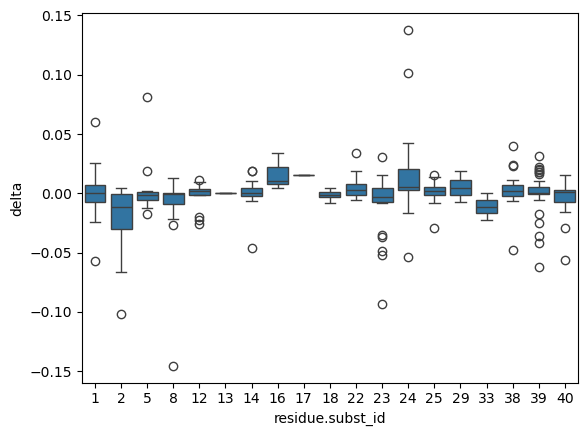

In [99]:
sns.boxplot(deltas, y='delta', x='residue.subst_id')